# MaskFormer for semantic segmentation

MaskFormer is currently one of the most SOTA model in image segmentation


## Load Data

In [1]:
# read data set
import os
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import copy

def read_data(root_path):
    data = []
    img_paths = []
    labels = []
    for label in os.listdir(root_path):
        if ".ipynb_checkpoints" in label:
            continue
        for image in os.listdir(os.path.join(root_path, label) + "/image"):
            path_to_img = os.path.join(os.path.join(root_path, label) + "/image", image)
            path_to_label = os.path.join(os.path.join(root_path, label) + "/label", image)
            if ".ipynb_checkpoints" in image:
                continue
            if os.path.exists(path_to_img) and os.path.exists(path_to_label):
                # create a new dictionary for each image
                sample = dict()
                print(id(sample))
                sample['pixel_values'] = Image.open(path_to_img).convert('RGB')
                sample['label'] = Image.open(path_to_label).convert('L')
                sample['img_path'] = path_to_img
                sample['label_path'] = path_to_label
                print(sample['img_path'])
                data.append(copy.deepcopy(sample))
                img_paths.append(path_to_img)
                labels.append(label)

    # creating df
    data_frame = pd.DataFrame({'img_path': img_paths, 'label': labels})
    print('len of data:', len(data))
    return data, data_frame

data,df = read_data("/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG")
            

132916184136960
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GT2012508-1-400-007.png
132916184469696
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GT2016846-3-400-001.png
132916334843520
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GT2017995-1-400-005.png
132916184472384
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GT2012436-1-400-003.png
132916184473728
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GTXC2015413-3-400-002.png
132916184475072
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GT2012196-2-400-001.png
132916542525440
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GTxc2012829-2-400-003.png
132916537176576
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GTXC2110128-2-400-006.png
132916184479488
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GTXC2015362-1-400-002.png
132916184473152
/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GTDC21

In [2]:
df

,img_path,label
0,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-...,High-grade IN
1,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-...,High-grade IN
2,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-...,High-grade IN
3,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-...,High-grade IN
4,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-...,High-grade IN
...,...,...
2221,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/Low-g...,Low-grade IN
2222,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/Low-g...,Low-grade IN
2223,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/Low-g...,Low-grade IN
2224,/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/Low-g...,Low-grade IN


In [3]:
data[126]['img_path']

'/kaggle/input/d/maitng/ebhi-seg/EBHI-SEG/High-grade IN/image/GTxc2012996-4-400-003.png'

In [4]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [5]:
!pip install -q datasets

In [6]:
!pip install -q albumentations

In [7]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    return [[120, 120, 120],  [92, 0, 255]]

palette = color_palette()

## Create Dataset


In [8]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['pixel_values'])
        original_segmentation_map = np.array(self.dataset[idx]['label'].convert('1'))*1

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

In [9]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    A.RandomCrop(width=224, height=224),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    A.Resize(width=224, height=224),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

## train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df, stratify = df['label'],test_size=0.2, random_state=42)
data_train = [data[i] for i in X_train.index]
data_test = [data[i] for i in X_test.index]

train_dataset = ImageSegmentationDataset(data_train, transform=train_transform)
test_dataset = ImageSegmentationDataset(data_test, transform=test_transform)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
image, segmentation_map, _, _ = train_dataset[80]

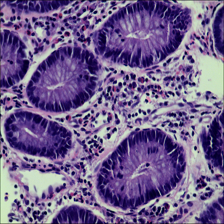

In [11]:
from PIL import Image

unnormalized_image = (image * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

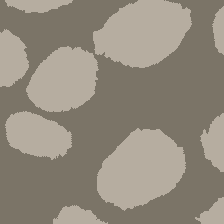

In [12]:
from PIL import Image


unnormalized_image = (segmentation_map * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [13]:
(segmentation_map * 255).astype(np.uint8)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

In [14]:
id2label = {0:'negative',1:'positive'}
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['negative', 'positive']


## Create PyTorch DataLoaders



In [15]:
from transformers import MaskFormerImageProcessor

# Create a preprocessor
preprocessor = MaskFormerImageProcessor(ignore_index=-1, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

/opt/conda/lib/python3.10/site-packages/transformers/models/maskformer/image_processing_maskformer.py:430: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [16]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # print(images[0].shape)
    # print(segmentation_maps[0].shape)
    # print(images[1].shape)
    # print(segmentation_maps[1].shape)
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

## Verify data


In [17]:
import torch

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([12, 3, 224, 224])
pixel_mask torch.Size([12, 224, 224])
mask_labels torch.Size([2, 224, 224])
class_labels torch.Size([2])
original_images (224, 224, 3)
original_segmentation_maps (224, 224)


In [18]:
pixel_values = batch["pixel_values"][0].numpy()
pixel_values.shape

(3, 224, 224)

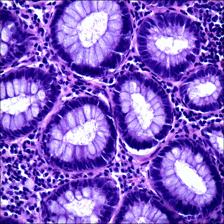

In [19]:
unnormalized_image = (pixel_values * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [20]:
id2label = {0:'negative',1:'positive'}

In [21]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Define model



In [22]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down

## Compute initial loss



In [23]:
outputs = model(batch["pixel_values"],
                class_labels=batch["class_labels"],
                mask_labels=batch["mask_labels"])

In [24]:
outputs.loss

tensor(2.6789, grad_fn=<AddBackward0>)

## Train the model



In [25]:
!pip install -q evaluate

In [26]:
import evaluate

metric = evaluate.load("mean_iou")

In [27]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
epochs = 10
for epoch in range(epochs):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

  model.eval()
  for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 19:
      break

    pixel_values = batch["pixel_values"]

    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)
    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)

  # NOTE this metric outputs a dict that also includes the mIoU per category as keys
  # so if you're interested, feel free to print them as well
  print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = -1)['mean_iou'])

Epoch: 0


  0%|          | 0/149 [00:00<?, ?it/s]

Loss: 0.25765444835027057
Loss: 0.1422809111599875


  0%|          | 0/56 [00:00<?, ?it/s]

Mean IoU: 0.7540673118868803
Epoch: 1


  0%|          | 0/149 [00:00<?, ?it/s]

Loss: 0.12722403293342463
Loss: 0.10670480478734257


  0%|          | 0/56 [00:00<?, ?it/s]

Mean IoU: 0.8365233328315391
Epoch: 2


  0%|          | 0/149 [00:00<?, ?it/s]

Loss: 0.09980586583309985
Loss: 0.0899642447301648


  0%|          | 0/56 [00:00<?, ?it/s]

Mean IoU: 0.8350003813671241
Epoch: 3


  0%|          | 0/149 [00:00<?, ?it/s]

Loss: 0.08655111520079219
Loss: 0.08132631014191041


  0%|          | 0/56 [00:00<?, ?it/s]

Mean IoU: 0.8576192114409084
Epoch: 4


  0%|          | 0/149 [00:00<?, ?it/s]

Loss: 0.07927359569560793
Loss: 0.07579676180262435


  0%|          | 0/56 [00:00<?, ?it/s]

Mean IoU: 0.8567851346251341
Epoch: 5


  0%|          | 0/149 [00:00<?, ?it/s]

Loss: 0.0743267648523971
Loss: 0.07152566997794128


  0%|          | 0/56 [00:00<?, ?it/s]

Mean IoU: 0.8610386338451611
Epoch: 6


  0%|          | 0/149 [00:00<?, ?it/s]

Loss: 0.07050026819706409
Loss: 0.06828403571640006


  0%|          | 0/56 [00:00<?, ?it/s]

Mean IoU: 0.8722425879058029
Epoch: 7


  0%|          | 0/149 [00:00<?, ?it/s]

Loss: 0.06745056037368723
Loss: 0.0656426877302165


  0%|          | 0/56 [00:00<?, ?it/s]

Mean IoU: 0.8705514916986709
Epoch: 8


  0%|          | 0/149 [00:00<?, ?it/s]

Loss: 0.06491552810010835
Loss: 0.06340565448740187


  0%|          | 0/56 [00:00<?, ?it/s]

Mean IoU: 0.8707954968826102
Epoch: 9


  0%|          | 0/149 [00:00<?, ?it/s]

Loss: 0.06277994998171182
Loss: 0.06157006027943134


  0%|          | 0/56 [00:00<?, ?it/s]

Mean IoU: 0.8740687159218121


In [36]:
model.eval()
for idx, batch in enumerate(tqdm(test_dataloader)):

    pixel_values = batch["pixel_values"]

    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)

# NOTE this metric outputs a dict that also includes the mIoU per category as keys
# so if you're interested, feel free to print them as well
# print("Mean IoU:", metric.compute(ignore_index=-1,num_labels = len(id2label))['mean_iou'])

  0%|          | 0/56 [00:00<?, ?it/s]

## Inference

In [38]:
print("Mean IoU:", metric.compute(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps, ignore_index=-1,num_labels = len(id2label))['mean_iou'])
print("Mean Accuracy:", metric.compute(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps, ignore_index=-1,num_labels = len(id2label))['mean_accuracy'])

Mean IoU: 0.8775660643301697
Mean Accuracy: 0.9111738868062454


In [40]:
from sklearn.metrics import precision_score, recall_score
def compute_metrics(predictions, labels, average='macro'):
    # Flatten the predictions and labels
    predictions = predictions.flatten()
    labels = labels.flatten()

    # Calculate Precision and Recall
    precision = precision_score(labels, predictions, average=average, zero_division=1)
    recall = recall_score(labels, predictions, average=average, zero_division=1)
    
    return precision, recall

In [46]:
predictions = np.array([tensor.cpu().numpy() for tensor in predicted_segmentation_maps])
ground_truths = np.array(batch["original_segmentation_maps"])
print(type(predictions))
precision, recall = compute_metrics(predictions, ground_truths)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

<class 'numpy.ndarray'>
Precision: 0.8965
Recall: 0.9112


In [29]:
# let's take the first test batch
batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([8, 3, 224, 224])
pixel_mask torch.Size([8, 224, 224])
mask_labels 8
class_labels 8
original_images 8
original_segmentation_maps 8


In [48]:
# forward pass
model.eval()
with torch.no_grad():
  outputs = model(batch["pixel_values"].to(device))

In [49]:
original_images = batch["original_images"]
target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
# predict segmentation maps
predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

## Visualize
idx = 1

(6, 224, 224, 3)


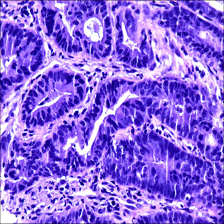

In [50]:
print(np.shape(batch["original_images"]))
idx = 2
image = batch["original_images"][idx]
Image.fromarray(image)

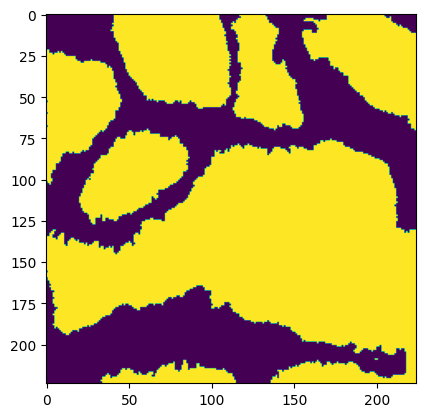

In [51]:
segmentation_map = batch["original_segmentation_maps"][idx]
plt.imshow(segmentation_map)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


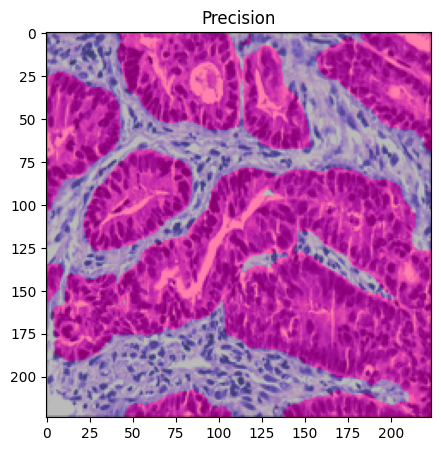

In [52]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = predicted_segmentation_maps[idx].cpu().numpy()
print(segmentation_map)
color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("Precision")
plt.show()

Compare to the ground truth:

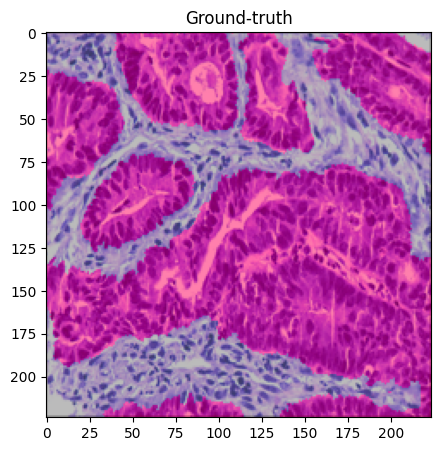

In [53]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = batch["original_segmentation_maps"][idx]

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("Ground-truth")
plt.show()